In [1]:
import random
import itertools

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection

In [2]:
def createLSTMLayers(n_layers, n_cells, dropout):
    cell_list = []
    
    for layer in range(n_layers):
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(n_cells, activation=tf.nn.relu, layer_norm=False)
        
        cell_list.append(cell)
        
    return cell_list

In [29]:
def padSeq(seqs, pad_length, right_pad=True):
    
    '''
    padSeq
    
    Pad sequences to be equal length.
    
    seqs: sequences to be padded
    pad_length: length to pad sequences
    left_pad: Pad at the end of the sequences, or reverse pad from front
    '''
    
    padded_seqs = np.zeros((len(seqs), pad_length))
    
    for idx_row, row in enumerate(seqs):
        for idx_col, col in enumerate(row):
            if right_pad:
                padded_seqs[idx_row, idx_col] = seqs[idx_row][idx_col]
            else:
                padded_seqs[idx_row, pad_length-idx_col-1] = seqs[idx_row][len(row)-idx_col-1]
    return padded_seqs

In [30]:
tf.reset_default_graph()

In [31]:
#Network parameters
encoder_layers = 1
encoder_cells = 5
encoder_dropout = 1

decoder_layers = 1
decoder_cells = 5
decoder_dropout = 1

seq_length = 5
n_features = 1

latent_dimensions = 2

#Training Parameters
lr = 0.001
batch_size = 128

In [32]:
inputs = tf.placeholder(name='input', shape=[None, seq_length, n_features], dtype=tf.float32)

In [33]:
#encoder
with tf.variable_scope('encoder', reuse=False):
    
    encoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    encoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    
    (encoder_fw_outputs, encoder_bw_outputs), encoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        encoder_cell_fw,
                                        encoder_cell_bw, 
                                        inputs=inputs,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    encoder_final_state = tf.concat([state_tuple[0].h for state_tuple in encoder_state_outputs], axis=1)

In [34]:
latent_vector_in = tf.contrib.layers.fully_connected(encoder_final_state, latent_dimensions, activation_fn=tf.nn.relu,
                                                    normalizer_fn=tf.contrib.layers.batch_norm)

In [35]:
latent_vector_out = tf.contrib.layers.fully_connected(latent_vector_in, decoder_cells, activation_fn=tf.nn.relu)

In [36]:
decoder_inputs = tf.zeros([tf.shape(inputs)[0], seq_length, n_features])

In [37]:
decoder_initial_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c=latent_vector_out, h=latent_vector_out) for i in 
                              range(decoder_layers)])

In [38]:
#decoder

with tf.variable_scope('decoder', reuse=False):
    
    decoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    decoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    
    (decoder_fw_outputs, decoder_bw_outputs), decoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        decoder_cell_fw,
                                        decoder_cell_bw, 
                                        inputs=decoder_inputs,
                                        initial_state_fw=decoder_initial_state,
                                        initial_state_bw=decoder_initial_state,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    decoder_outputs = tf.concat([decoder_fw_outputs, decoder_bw_outputs], axis=2)

In [39]:
output_layer = tf.contrib.layers.fully_connected(decoder_outputs, n_features, activation_fn=tf.nn.relu)

In [40]:
loss = tf.reduce_sum(tf.square(inputs-output_layer))

In [41]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [42]:
def generatePseudoSequences(seq_length, low, high, n_seqs, seed, variable_length=False):
    
    '''
    generatePseudoSequences
    
    seq_length: Length of sequence to generate
    low: lower bound of values
    high: upper bound of values
    n_seqs: number of sequences to generate
    variable_length: Create sequence of variable length    
    '''
    random.seed(seed)
    #Generate random sequences
    random_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        current_seq = [random.randint(low, high) for _ in range(current_length)]
        
        random_seqs.append(current_seq)
        
    #Generate repeating sequences
    
    repeat_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value for _ in range(current_length)]
        
        repeat_seqs.append(current_seq)
        
    return repeat_seqs

In [43]:
df_seqs = pd.DataFrame(padSeq(generatePseudoSequences(5, 1, 10, 50000, 0, variable_length=False), 5))

In [44]:
seq_cols = df_seqs.columns.values

In [45]:
df_seqs['label'] = df_seqs[seq_cols].apply(lambda x:'_'.join([str(i) for i in x]), axis=1)

In [46]:
df_seqs['label'].value_counts()

6.0_6.0_6.0_6.0_6.0         5142
2.0_2.0_2.0_2.0_2.0         5091
7.0_7.0_7.0_7.0_7.0         5034
5.0_5.0_5.0_5.0_5.0         5018
1.0_1.0_1.0_1.0_1.0         4978
10.0_10.0_10.0_10.0_10.0    4962
9.0_9.0_9.0_9.0_9.0         4953
3.0_3.0_3.0_3.0_3.0         4948
8.0_8.0_8.0_8.0_8.0         4940
4.0_4.0_4.0_4.0_4.0         4934
Name: label, dtype: int64

In [47]:
df_train, df_test = model_selection.train_test_split(df_seqs, test_size=0.2)

In [48]:
#training

n_epochs = 50

n_batches = df_train.shape[0]//batch_size

In [49]:
print (n_epochs, n_batches)

50 312


In [50]:
results[2]

array([[ 236.81265259,    0.        ],
       [  36.28363419,    0.        ],
       [ 385.15914917,    0.        ],
       [ 433.4881897 ,    0.        ],
       [ 481.52926636,    0.        ],
       [  36.28363419,    0.        ],
       [ 132.7492218 ,    0.        ],
       [ 481.52926636,    0.        ],
       [ 185.18772888,    0.        ],
       [  36.28363419,    0.        ],
       [ 385.15914917,    0.        ],
       [ 481.52926636,    0.        ],
       [ 385.15914917,    0.        ],
       [ 336.45236206,    0.        ],
       [ 433.4881897 ,    0.        ],
       [ 132.7492218 ,    0.        ],
       [ 287.13442993,    0.        ],
       [ 336.45236206,    0.        ],
       [ 132.7492218 ,    0.        ],
       [ 336.45236206,    0.        ],
       [  36.28363419,    0.        ],
       [  36.28363419,    0.        ],
       [ 385.15914917,    0.        ],
       [ 132.7492218 ,    0.        ],
       [  81.57950592,    0.        ],
       [ 132.7492218 ,   

In [ ]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')
    
    for c_epoch in range(n_epochs):
        df_epoch_samples = df_train[seq_cols].sample(frac=1)
        for c_batch in range(n_batches): 
            batch = df_epoch_samples[c_batch*batch_size:(c_batch+1)*batch_size].values
            batch = batch.reshape(len(batch), seq_length, 1)
            results = sess.run([optimizer, loss, latent_vector_in, output_layer], {inputs:batch})
            
            if c_batch%100==0:
                print ('epoch:%d, batch:%d, loss:%.3g' % (c_epoch, c_batch, results[1]))
    
    latent_vectors = sess.run(latent_vector_in, {inputs:df_train[seq_cols].values.reshape(df_train.shape[0], seq_length, 1)})

Begin training
epoch:0, batch:0, loss:2.15e+04
epoch:0, batch:100, loss:1.78e+04
epoch:0, batch:200, loss:3.4e+03
epoch:0, batch:300, loss:263
epoch:1, batch:0, loss:329
epoch:1, batch:100, loss:317
epoch:1, batch:200, loss:240
epoch:1, batch:300, loss:100
epoch:2, batch:0, loss:84.8
epoch:2, batch:100, loss:42.6
epoch:2, batch:200, loss:43.1
epoch:2, batch:300, loss:74.7
epoch:3, batch:0, loss:96.7
epoch:3, batch:100, loss:53.1
epoch:3, batch:200, loss:112
epoch:3, batch:300, loss:180
epoch:4, batch:0, loss:83.6
epoch:4, batch:100, loss:83.7
epoch:4, batch:200, loss:120
epoch:4, batch:300, loss:207
epoch:5, batch:0, loss:39.6
epoch:5, batch:100, loss:37.5
epoch:5, batch:200, loss:360
epoch:5, batch:300, loss:261
epoch:6, batch:0, loss:43.9
epoch:6, batch:100, loss:48.1
epoch:6, batch:200, loss:75.8
epoch:6, batch:300, loss:101
epoch:7, batch:0, loss:118
epoch:7, batch:100, loss:170
epoch:7, batch:200, loss:113
epoch:7, batch:300, loss:78.6
epoch:8, batch:0, loss:56.6
epoch:8, batch:10

In [112]:
df_vectors = pd.DataFrame(latent_vectors, columns=['x', 'y'])

In [113]:
df_seqs_vectors = df_seqs.merge(df_vectors, left_index=True, right_index=True)

In [114]:
palette = itertools.cycle(sns.color_palette())

In [115]:
unique_seqs = df_seqs_vectors['label'].unique()

In [118]:
df_seqs_vectors[df_seqs_vectors[0]==2]

,0,1,2,3,4,label,x,y
0,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,1.971067,0.724874
2,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,3.419610,0.721450
16,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,1.038963,0.655426
22,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,3.419610,0.721450
39,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,2.721335,0.754503
42,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,2.721335,0.754503
46,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,2.721335,0.754503
68,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,2.721335,0.754503
75,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,3.419610,0.721450
76,2.0,2.0,2.0,2.0,2.0,2.0_2.0_2.0_2.0_2.0,4.122154,0.643280


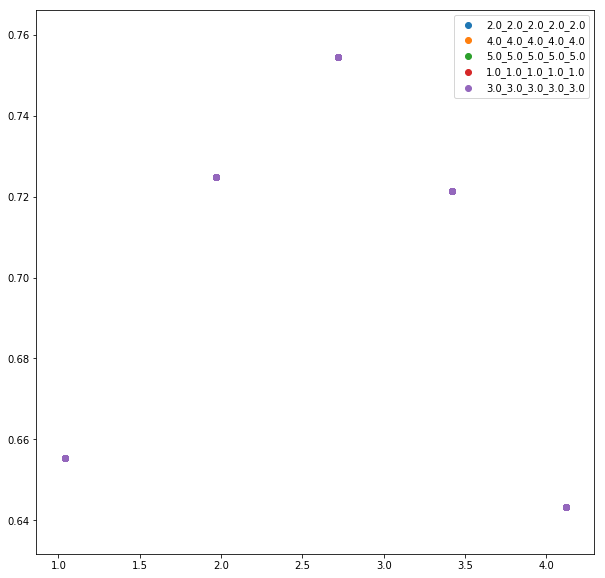

In [116]:
#Analysis

plt.figure(1, figsize=(10, 10))

for seq in unique_seqs:
    df_current = df_seqs_vectors[df_seqs_vectors['label']==seq]
    plt.scatter(df_current['x'].values, df_current['y'].values, color=next(palette), label=seq)

plt.legend(loc='best')
plt.show()